In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud ,STOPWORDS

%matplotlib inline

In [3]:
import  textblob
from textblob import TextBlob
from textblob import Word

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arnav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Importing the data

In [5]:
yelp = pd.read_csv('input/yelp.csv')

In [6]:
yelp.shape

(10000, 10)

In [7]:
yelp.head(3)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0


### Explorartory analysis

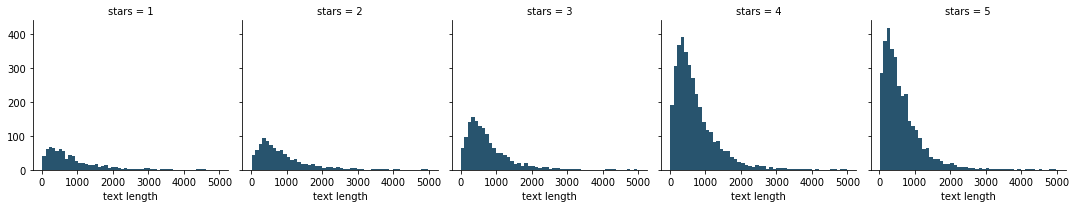

In [8]:
yelp['text length'] = yelp['text'].apply(len)
g = sns.FacetGrid(data=yelp, col='stars')
g.map(plt.hist, 'text length', bins=50, color='#28546E')
plt.savefig('stars_textlen', dpi=200)

#### _However, the number of text reviews seems to be skewed a lot higher towards the 4-star and 5-star ratings. This may cause some issues later on in the process.___

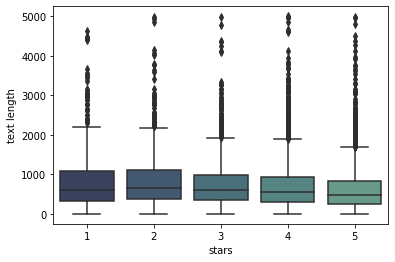

In [9]:
sns.boxplot(x='stars', y='text length', data=yelp, palette=sns.cubehelix_palette(9, start=.4, rot=-.70, reverse=True, light=0.85, dark=0.25))
plt.savefig('stars_textlen_box', dpi=200)

#### From the plot, looks like the 1-star and 2-star ratings have much longer text, but there are many outliers (which can be seen as points above the boxes). 

___Because of this, maybe text length won’t be such a useful feature to consider after all.___

In [10]:
stars = yelp.groupby('stars').mean()
stars

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


In [11]:
stars.corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


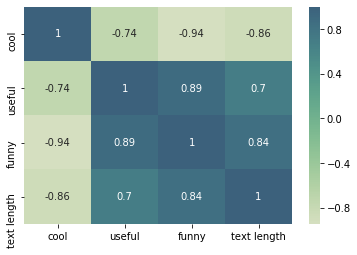

In [12]:
cmap = sns.cubehelix_palette(9, start=.4, rot=-.70, as_cmap=True, reverse=False, light=0.85, dark=0.35)
sns.heatmap(data=stars.corr(), annot=True, cmap=cmap)
plt.savefig('heatmap', dpi=200)

#### Looking at the map, funny is strongly correlated with useful, and useful seems strongly correlated with text length. We can also see a negative correlation between cool and the other three features.


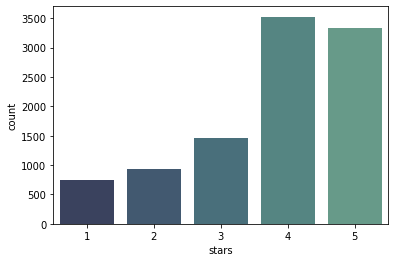

In [13]:
sns.countplot(x='stars', data=yelp, palette=sns.cubehelix_palette(9, start=.4, rot=-.70, reverse=True, light=0.85, dark=0.25))

####  rating 4 and 5 are much more in data. we may have to balance the data for training purpose.

### NLP Classification Task
Our task is to predict if a review is either bad or good, so let’s jlabelreviews as positive with rating 4 and 5, neutral for rating 3 and rest as negative.
Store the sentiment in new column 'sentiment' of yelp dataset

In [15]:
# Labelling the sentiment based on rating (5,4 starts): positive-3: neutral-2, (stars1,2): negative-1
yelp['sentiment']=np.where((yelp.stars==5)|(yelp.stars==4),3,np.where(yelp.stars==3,2,1))

In [16]:
yelp.sentiment.value_counts()

3    6863
1    1676
2    1461
Name: sentiment, dtype: int64

### Text pre-processing

In [17]:
from sklearn.model_selection import train_test_split

In [19]:
orig_x=yelp['text']
orig_y=yelp['sentiment']

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(orig_x, orig_y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(7500,)
(2500,)
(7500,)
(2500,)


In [21]:
stop = set(nltk.corpus.stopwords.words('english'))

In [22]:
import string

In [23]:
import string
def pre_process(text):
    
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stop)) #Removing stop words
    #text = text.apply(lambda x: " ".join(PorterStemmer().stem(word) for word in x.split())) #Stemming using porter stemmer
   # text = text.apply(lambda x: str(TextBlob(x).correct()))                      #Correct spelling corrections
    
    return(text)

In [24]:
yelp_text=pre_process(yelp['text'])

In [25]:
x_train=pre_process(X_train)
x_test=pre_process(X_test)

### Vectorization

In [26]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,2), min_df=5,max_features=800)
tfidf_vect_ngram.fit(yelp_text)

x_train_trans = tfidf_vect_ngram.transform(x_train)
x_test_trans= tfidf_vect_ngram.transform(x_test)


In [27]:
x_train_trans.toarray().shape

(7500, 800)

### classes are impbalanced so performing oversampling-SMOTE

In [28]:
sm = SMOTE(random_state=2)


In [29]:
x_train_res, y_train_res = sm.fit_resample(x_train_trans,Y_train)


In [30]:
x_train_res.shape

(15441, 800)

### Classification 

In [31]:
nb = MultinomialNB()
nb.fit(x_train_res, y_train_res)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [32]:
pred1=nb.predict(x_train_res)

In [34]:
from sklearn.metrics import confusion_matrix, classification_report

In [35]:

print(confusion_matrix(y_train_res, pred1))
print('\n')
print(classification_report(y_train_res, pred1))

[[3824  966  357]
 [ 772 3647  728]
 [ 562  929 3656]]


              precision    recall  f1-score   support

           1       0.74      0.74      0.74      5147
           2       0.66      0.71      0.68      5147
           3       0.77      0.71      0.74      5147

    accuracy                           0.72     15441
   macro avg       0.72      0.72      0.72     15441
weighted avg       0.72      0.72      0.72     15441



In [38]:
preds=nb.predict(x_test_trans)

In [39]:
print(confusion_matrix(Y_test, preds))
print('\n')
print(classification_report(Y_test, preds))

[[ 278  111   30]
 [  72  205   88]
 [ 222  316 1178]]


              precision    recall  f1-score   support

           1       0.49      0.66      0.56       419
           2       0.32      0.56      0.41       365
           3       0.91      0.69      0.78      1716

    accuracy                           0.66      2500
   macro avg       0.57      0.64      0.58      2500
weighted avg       0.75      0.66      0.69      2500



In [40]:
wordcloud = WordCloud(stopwords=stop).generate(' '.join(x_train.tolist()))

%matplotlib inline
fig = plt.figure(figsize=(200,100))
plt.imshow(wordcloud)